"""
### Problem Statement ###

Task: A sentiment analysis of negative McDonald's reviews. 

Contributors were given reviews culled from low-rated McDonald's from random metro areas and asked to classify why the
locations received low reviews in at-least one of the below categories. 

Data is not tagged. For each entry you have to first perform sentiment analysis and then identify why the customer was unhappy.
Your reason should be atleast-one of the below or Not Applicable.

Slow Service
Problem with Order
Bad Food
Bad Neighborhood
Dirty Location
Cost
Rude Service

### Overview of solution ###

In this notebook, below steps are oerformed

Reviews of McDonald store are cleaned and Lemmatized

McDonald reviews are analyzed for positive or negative sentiments using TextBlob.
Sentiment values are stored in "sentiment" column.

0 = Negative review
1 = Positive review

After that, For all the negative reviews scores are generated for all the negative labels out of 1 using 
Zero Shot Classification.

Labels are as given below :
["slow service", "problem with order", "bad food", "bad neighborhood", "dirty location", "high cost", "rude service"]

Labels having score greater than or equal to 0.30 can be considered as one of the possible reasons among others(if any)
that the review was negative.

If any label does not have score greater than or equal to 0.30 then the label can be considered as "Not Applicable".
Value "1" can be seen in "not_applicable" column indicating this.

"""

In [1]:
%config Completer.use_jedi = False

In [ ]:
# !pip install modin[ray] #or modin[dask]
# import modin.pandas as pd

In [2]:
import pandas as pd
import re

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('max_rows', None)

In [4]:
og_df = pd.read_csv("og_data.csv", encoding="ISO-8859-1")
og_df.head()

,review
0,"I'm not a huge mcds lover, but I've been to better ones. This is by far the worst one I've ever been too! It's filthy inside and if you get drive through they completely screw up your order every time! The staff is terribly unfriendly and nobody seems to care."
1,"Terrible customer service. Î¾I came in at 9:30pm and stood in front of the register and no one bothered to say anything or help me for 5 minutes. Î¾There was no one else waiting for their food inside either, just outside at the window. Î¾ I left and went to Chickfila next door and was greeted before I was all the way inside. This McDonalds is also dirty, the floor was covered with dropped food. Obviously filled with surly and unhappy workers."
2,"First they ""lost"" my order, actually they gave it to someone one else than took 20 minutes to figure out why I was still waiting for my order.They after I was asked what I needed I replied, ""my order"".They asked for my ticket and the asst mgr looked at the ticket then incompletely filled it.I had to ask her to check to see if she filled it correctly.She acted as if she couldn't be bothered with that so I asked her again.She begrudgingly checked to she did in fact miss something on the ticket.So after 22 minutes I finally had my breakfast biscuit platter.As I left an woman approached and identified herself as the manager, she was dressed as if she had just awoken in an old t-shirt and sweat pants.She said she had heard what happened and said she'd take care of it.Well why didn't she intervene when she saw I was growing annoyed with the incompetence?"
3,I see I'm not the only one giving 1 star. Only because there is not a -25 Star!!! That's all I need to say!
4,"Well, it's McDonald's, so you know what the food is. Î¾This review reflects solely on the poor service. Î¾I have been to this location countless times over the years. Î¾They consistently fail on the service end of things. Î¾The order takers tend to be rude, no smiles, and a lot of ""sighs"" and ""lip smacking"" when you talk to them. Î¾So why go back you ask? This store benefits from being the only place to eat in this area. Î¾The next stop is at least 12 minutes away on the other side of town. Î¾Also I strongly believe in 2nd chances and know that not every business can satisfy everyone 100% of the time. Î¾I have given them many chances at earning a positive review. Î¾I could not recommend this location any less. Î¾If you can wait, take a pass. Î¾There are better McDonald's stores in Griffin, GA."


### Text Cleaning

In [5]:
def remove_re(text, pattern):
    re_obj = re.compile(pattern)
    text = re_obj.sub(r"", text)
    return text

In [6]:
og_df["clean_review"] = og_df["review"].apply(lambda x : remove_re(x, "@[\w]*"))

In [7]:
# remove special characters
og_df["clean_review"] = og_df["clean_review"].apply(lambda x : remove_re(x, "[^a-zA-Z# ]"))

In [8]:
# Remove stop words and transform into lower case

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

def remove_stop_words(text):
    word_tokens = word_tokenize(text)
    filtered_sentence = [w.lower() for w in word_tokens if not w in stop]
    filtered_text = " ".join(filtered_sentence)
    return filtered_text


In [9]:
og_df["clean_review"] = og_df["clean_review"].apply(lambda x : remove_stop_words(x))

In [10]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from collections import Counter

lemmatizer = WordNetLemmatizer()

def get_pos(word):
    
    w_synsets = wordnet.synsets(word)
    pos_counts = Counter()
    pos_counts["n"] = len(  [item for item in w_synsets if item.pos()=="n"]  )#Noun
    pos_counts["v"] = len(  [item for item in w_synsets if item.pos()=="v"]  )#Verb
    pos_counts["a"] = len(  [item for item in w_synsets if item.pos()=="a"]  )#Adjective
    pos_counts["r"] = len(  [item for item in w_synsets if item.pos()=="r"]  )#Adverb
    most_common_pos_list = pos_counts.most_common(3)
    
    return most_common_pos_list[0][0]

def to_lemma(text):
    
    tokens = word_tokenize(text)
    lemmas = []
    
    for i in tokens:
        lemma = lemmatizer.lemmatize(i, get_pos(i))
        lemmas.append(lemma)
        
    final_text = " ".join(lemmas)
    
    return final_text

In [11]:
og_df["clean_review"] = og_df["clean_review"].apply(lambda x : to_lemma(x))

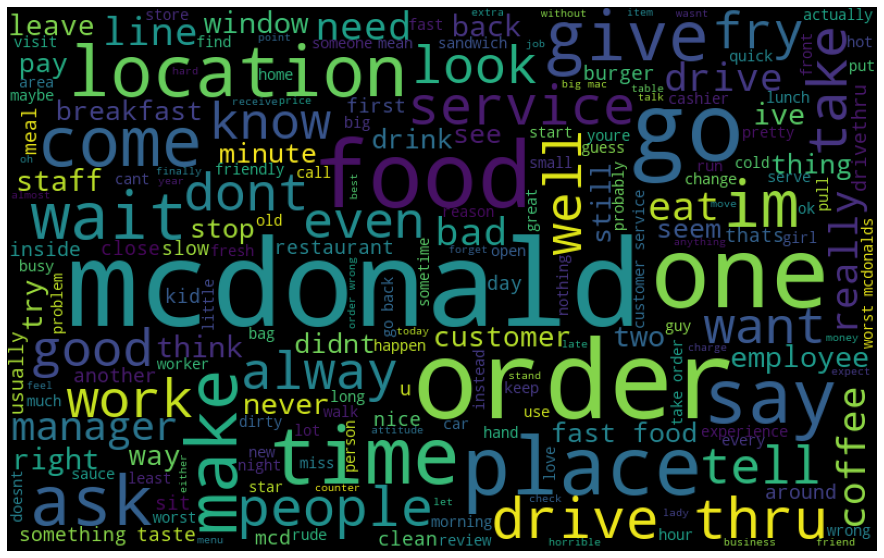

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Word CLoud

wCLoud = WordCloud(width=800, height=500, random_state=10, max_font_size=110
                  ).generate(" ".join([text for text in og_df["clean_review"]]))

plt.figure(figsize=(16, 10))
plt.imshow(wCLoud)
plt.axis("off")
plt.show()

In [13]:
stop = list(stop)
stop = stop + ["mcdonald", "mcd", "mcdonalds", "mac", "big mac", "bigmac"]
stop = set(stop)

In [14]:
og_df["clean_review"] = og_df["clean_review"].apply(lambda x : remove_stop_words(x))

In [15]:
og_df.sample(50)

,review,clean_review
1395,"Apparently also doubles as a group home for people with brain injuries. Î¾Can I get a Bacon, Egg and Cheese biscuit with a hot, steamy side of batshit crazy???",apparently also double group home people brain injury get bacon egg cheese biscuit hot steamy side batshit crazy
91,"I'm hooked on the McDonald's Oatmeal!When I want to grab some breakfast that's yummy, healthy, and easy to eat while I'm driving I head here. I'm always met with friendly service at the drive-through. They move pretty quickly and always get my order correct no matter how busy they are!",im hook oatmealwhen want grab breakfast thats yummy healthy easy eat im drive head im always meet friendly service drivethrough move pretty quickly always get order correct matter busy
1341,"I'm almost never in Mickey D's (no offense to anyone who's a fan), but I'm on a health kick and the only times I go there are with a coworker who has a coupon or for the Fish O Filets which i do admit I like. Î¾The two times I've been to this particular McD's are on a weekday at 3pm and a weekend morning at 10:30am - both NOT busy times. Î¾They honored our coupon for ""Two for One"" Fish O Filets, even though the coupon was half ripped so I have no complaints. Both times I got my food quick and the service was polite. Î¾ I can't say how this place is during rush hour, but with 6 cash registers open and the space being small... i can only imagine, it can get ugly in a hurry. Î¾However, the times I was there was A-OK",im almost never mickey offense anyone fan im health kick time go coworker coupon fish filet admit like two time ive particular mcds weekday pm weekend morning busy time honor coupon two one fish filet even though coupon half rip complaint time get food quick service polite cant say place rush hour cash register open space small imagine get ugly hurry however time aok
535,"The drive-thru menu board has changed making it impossible to find the items I usually order. Î¾Not sure if its just this location or all McDonalds, anything with mayonnaise will have enough mayo for three sandwiches and enough bread for almost 6 sandwiches compared to the amount of meat. If you request mustard instead of mayonnaise make sure you ask for mustard at the second window because you're getting dry sandwiches.",drivethru menu board change make impossible find item usually order sure location anything mayonnaise enough mayo three sandwich enough bread almost sandwich compare amount meat request mustard instead mayonnaise make sure ask mustard second window youre get dry sandwich
66,Just sat at drive thru several minutes no one is answering. I can see employees walking around and it is 5:48 am and they should be open. I wonder if this franchises owner is aware that he is losing business due to this. I bet they do and dont care.,sit drive thru several minute one answer see employee walk around open wonder franchise owner aware lose business due bet dont care
453,"This McDonald's is very clean. I don't eat fast food often,but I have returned to this location a few times.I can say the people who work here are nice and very fast. The only thing that is not great are the restrooms are old but it is in a gas station.",clean dont eat fast food oftenbut return location timesi say people work nice fast thing great restroom old gas station
1256,Do You want a close-ghetto experience?! Welcome to McSuck!,want closeghetto experience welcome mcsuck
363,"I would never usually review a McDonalds, but here's why this place rules:1) $5 for a 20 pack of Chicken McNuggets at 3am. When everything else in the food court was closed, we had this trusty option which ended up being our ""go to"". I couldn't imagine how extra hungover I would've been each morning without this grease.2) An alternative to overpriced breakfast at the buffet at the hotel.3) A quick way of grabbing something for less than $5 when not needing a full meal during the day.5 stars for that!",would never usually review plac

### Sentiment Analysis

In [16]:
# !pip install vaderSentiment

In [17]:
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\DixitShi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [18]:
vds = SentimentIntensityAnalyzer()

In [19]:
text = "1/2/15so I have had 1 good experience and many bad. Î¾this time I remembered to take a photo literally looks like they threw my burger Î¾at the wall. I had to rebuild my own burger and then the holiday pie was burnt. why in God's sweet name would you serve that somebody. Î¾anyway I am a mall employee so I will probably be back there do lack of options but I hope for a better experience in the furture."
vds.polarity_scores(text)

#Observation after manually evaluating vader and textblob for sentiment analysis with many samples from dataset.
#Textblob seems to be working better at sentiment analysis for this dataset.

{'neg': 0.049, 'neu': 0.761, 'pos': 0.19, 'compound': 0.8847}

In [20]:
# !pip install textblob

In [21]:
from textblob import TextBlob

In [22]:
text = "BEWARE: There is a guy who works here, tall, glasses and painfully forgetful. I've gone here a total of three times in the past month for a quick fix with my siblings and he's gotten our order wrong each of those times. He must be new, but he does seem genuinely sorry after he adds or subtracts something from our order.Regardless, he's not why I give this McDonalds 1 star.This place is usually jam packed with teens by 1pm during the school year and during the summer, just can't catch a break. Location is usually messy and has THE LOUDEST DOOR EVER! Service is mediocre to the max, then again, this is McDonalds, no 5 star review here."
TextBlob(text).sentiment

#Observation after manually evaluating vader and textblob for sentiment analysis with many samples from dataset.
#Textblob seems to be working better at sentiment analysis for this dataset.

Sentiment(polarity=-0.18803030303030305, subjectivity=0.5904545454545455)

In [23]:
def classify_sentiment(text):
    score = TextBlob(text).sentiment.polarity
    if score > 0.1:
        result = 1  #positive sentiment
    else:
        result = 0  #negative sentient
    return result

In [24]:
og_df["sentiment"] = og_df["clean_review"].apply(lambda x : classify_sentiment(x))

In [25]:
og_df.sentiment.value_counts()

0    1047
1     478
Name: sentiment, dtype: int64

In [27]:
og_df[og_df["sentiment"]==1].sample(50)

,review,clean_review,sentiment
96,"This location has the new strawberry creme pies. The healthscore is a 93 as of 3/26/12.The drive thru cashier was really nice, but my fries were far too crispy too be any good.",location new strawberry creme pie healthscore drive thru cashier really nice fry far crispy good,1
1124,"Considering it's in a pretty crappy area, I could not give this place more than 3 stars. Additionally, it IS McDonald's. I went to the drive-thru the other morning to get an iced coffee and they were pretty busy (which is good). However, if you are in a hurry and need to get to USC or your work place, I would not recommend coming here because it always seems to be packed. Anyways, its McDonald's. Its not much different than the others.",consider pretty crappy area could give place star additionally go drivethru morning get ice coffee pretty busy good however hurry need get usc work place would recommend come always seem pack anyways much different others,1
640,"Yeah, I know. Î¾McDonald's. Î¾If I rated the 500 best burgers I've had, none would be McDonald's. Î¾Sometimes though, convenience rules.If that's the case, this particular McDonald's flat out executes what they are supposed to in fast food. Î¾It's hot, it's fresh, it's clean, and they are quick. Î¾The fries (a particular highlight) are consistently hot, nicely salted and made right.The best fast food in our area is that one particular DQ over on MacArthur Boulevard (I've reviewed that one), but this Mickey D's has a drive-thru and is 24 hours.If you're in a pinch and need a fast food fix, this is the place to go in Central 'Couv.",yeah know rat best burger ive none would sometimes though convenience rulesif thats case particular flat execute suppose fast food hot fresh clean quick fry particular highlight consistently hot nicely salt make rightthe best fast food area one particular dq macarthur boulevard ive review one mickey drivethru hoursif youre pinch need fast food fix place go central couv,1
303,"The Mickey D's breakfast vibe was strong in the work space and several of us were looking for some extra calories to fuel the early morning mental dash. Î¾Given there was four of us with one getting a meal for another be opted to go inside. Î¾Chaos an only describe the inside. Î¾The wait, the ordering process, the retrieval of food seemed very disorganized and confusing. Î¾When my order did pop up I did a quick cursory inspection of the two bags and was out the door. Î¾We orbited the drive-thru (which is long) and noticed it was full of cars. Î¾I was initially thankful we went indoors to make our orders. Î¾It was only when we arrived back at the office did I notice that I was not F&*%ed at drive-thru but F%$#ed in the interior. Î¾My order was wrong and.....I am ashamed to admit...I did not notice they did not give me my coffee (no exclamation mark needed). Î¾And so began the internal debate with myself, just whose responsibility was it to make sure I got my coffee? Î¾I then decided it was both mine and theirs,,,but mostly theirs. Î¾When I am starving in the morning from here on out, I will just wait for lunch.",mickey breakfast vibe strong work space several u look extra calorie fuel early morning mental dash give four u one get meal another opt go inside chaos describe inside wait order process retrieval food seem disorganize confuse order pop quick cursory inspection two bag door orbit drivethru long notice full car initially thankful go indoors make order arrive back office notice feed drivethru f # ed interior order wrong andi ashamed admiti notice give coffee exclamation mark need begin internal debate whose responsibility make sure get coffee decide mine theirsbut mostly starve morning wait lunch,1
414,"My least favorite fast food place but my daughter's favorite so we make the appearance every now and then. Î¾McDonalds has the best kids meals and playplaces so for my seven year old this is a great place. Î¾Love the apple slices and much smaller fry bags

In [28]:
og_df[og_df["sentiment"]==0].sample(50)

,review,clean_review,sentiment
114,"this is CLEARLY a franchise location, and they.do.not.care. This place is a cash cow. The staff is totally random (have had some decent service, and times I would be better going to the overpriced gas station next door).Clearly the new/bigger menu has the staff utterly overwhelmed. (oh, when a place has ""NOW HIRING ALL SHIFTS"" signs up for ever...be warned.... there is one elderly latina lady at the drive thru whose 'here you go hun' and smile could melt and iceberg- what a joy! but...once had horrible service- complained and got an out of date coupon for one small sandwich, fries, and drink. really?",clearly franchise location theydonotcare place cash cow staff totally random decent service time would well go overprice gas station next doorclearly newbigger menu staff utterly overwhelm oh place hire shift sign everbe warn one elderly latina lady drive thru whose go hun smile could melt iceberg joy butonce horrible service complain get date coupon one small sandwich fry drink really,0
623,I'd give zero stars or negative if it were possible. This McDonald's threatens to tow anyone who parks in the expansive lot next door. Even when it is almost always vacant. And this reach of jerkiness extends to the alley parking behind over and out. Seriously?! A parking lot that would more than accommodate both your clientele And that of the nearby observatory restaurant? Not cool bro. Not cool at all.,id give zero star negative possible threaten tow anyone park expansive lot next door even almost always vacant reach jerkiness extend alley parking behind seriously parking lot would accommodate clientele nearby observatory restaurant cool bro cool,0
172,"This is the only burger place within 5 minutes of my office so I've been going here to pick up my lunch before starting work. However, this morning I get there at 10:25 because i have to be at work at 10:35. I try to order a chicken wrap and I'm told they can't take lunch orders until 10:30. Now up until recently I worked in the food industry for 14 years as a manager and I understand the reason for these time frames for breakfast and lunch, but at 5 minutes till I can get a wrap so I can make it to my office with lunch on time? I asked the order taker if they could please help me out it was only 5 minutes and they flat out refused. OUTSTANDING CUSTOMER SERVICE GUYS!! Won't be going back. There is a Vons, a Port of Subs, a Panda Express, an Ensteins Bagels, 2 Pizza Places, and a couple of other restraunts all in the same shopping center so just keep pushing business away to your competitors.Monday June 9, 2014 10:45 am",burger place within minute office ive go pick lunch start work however morning get work try order chicken wrap im tell cant take lunch order recently work food industry year manager understand reason time frame breakfast lunch minute till get wrap make office lunch time ask order taker could please help minute flat refuse outstanding customer service guy wont go back vons port sub panda express ensteins bagel pizza place couple restraunts shop center keep push business away competitorsmonday june,0
1441,"Wow, I can't believe I'm giving this place its first 5 star rating. I come here late at night after I get out of work. Needless to say, the service is fast, the people are friendly, and the food is prepared right. I also like the fact that they're dine is open late at night so I can eat inside rather than have to take my food home.",wow cant believe im give place first star rat come late night get work needle say service fast people friendly food prepare right also like fact theyre dine open late night eat inside rather take food home,0
674,"Ordered the silver meal and asked for the nuggets and the French fries to be cooked fresh, as they took the 3 minutes to get my order together they giver my food and I have cold fries and even colder nuggets. My wife takes on fry back because the kids are hungry and okay with any French fry and I take

### Multilabel classification for finding the reason of negative review

In [29]:
# !pip install transformers

In [30]:
from transformers import pipeline

In [31]:
classifier = pipeline("zero-shot-classification")

In [32]:
candidate_labels = ["slow service", "problem with order", "bad food", "bad neighborhood", "dirty location", "high cost", "rude service"]

In [100]:
def reason_negative_sentiment(row):
    
    result = classifier(row["clean_review"], candidate_labels)
    label_list = [0,0,0,0,0,0,0,0]
    
    if row["sentiment"] == 0:
        
        if result["scores"][0] < 0.30:
            #not_applicale
            label_list[7] = 1
            
        label_list[0] = result["scores"][result["labels"].index("slow service")]
        label_list[1] = result["scores"][result["labels"].index("problem with order")]
        label_list[2] = result["scores"][result["labels"].index("bad food")]
        label_list[3] = result["scores"][result["labels"].index("bad neighborhood")]
        label_list[4] = result["scores"][result["labels"].index("dirty location")]
        label_list[5] = result["scores"][result["labels"].index("high cost")]
        label_list[6] = result["scores"][result["labels"].index("rude service")]
            
    return label_list

In [93]:
og_df.shape

(1525, 3)

In [94]:
scores = og_df.apply(lambda row : reason_negative_sentiment(row), axis=1)

In [105]:
result_df = pd.DataFrame(list(scores), columns = ['slow_service', 'incorrect_order', 'bad_food', 'bad_neighborhood', 'dirty_location', 'cost', 'rude_service', 'not_applicable'])

In [97]:
final_df = pd.concat([og_df, result_df], axis=1, join='inner')

In [106]:
final_df.shape

(1525, 11)

In [107]:
final_df.columns

Index(['review', 'clean_review', 'sentiment', 'slow_service',
       'incorrect_order', 'bad_food', 'bad_neighborhood', 'dirty_location',
       'cost', 'rude_service', 'not_applicable'],
      dtype='object')

In [102]:
final_df.head(50)

,review,clean_review,sentiment,slow_service,incorrect_order,bad_food,bad_neighborhood,dirty_location,cost,rude_service,not_applicable
0,"I'm not a huge mcds lover, but I've been to better ones. This is by far the worst one I've ever been too! It's filthy inside and if you get drive through they completely screw up your order every time! The staff is terribly unfriendly and nobody seems to care.",im huge mcds lover ive well one far worst one ive ever filthy inside get drive completely screw order every time staff terribly unfriendly nobody seem care,0,0.061751,0.151087,0.003350,0.022808,0.335983,0.004412,0.420609,0
1,"Terrible customer service. Î¾I came in at 9:30pm and stood in front of the register and no one bothered to say anything or help me for 5 minutes. Î¾There was no one else waiting for their food inside either, just outside at the window. Î¾ I left and went to Chickfila next door and was greeted before I was all the way inside. This McDonalds is also dirty, the floor was covered with dropped food. Obviously filled with surly and unhappy workers.",terrible customer service come pm stand front register one bother say anything help minute one else wait food inside either outside window leave go chickfila next door greet way inside also dirty floor cover drop food obviously fill surly unhappy worker,0,0.315454,0.024646,0.009313,0.009861,0.262499,0.002065,0.376163,0
2,"First they ""lost"" my order, actually they gave it to someone one else than took 20 minutes to figure out why I was still waiting for my order.They after I was asked what I needed I replied, ""my order"".They asked for my ticket and the asst mgr looked at the ticket then incompletely filled it.I had to ask her to check to see if she filled it correctly.She acted as if she couldn't be bothered with that so I asked her again.She begrudgingly checked to she did in fact miss something on the ticket.So after 22 minutes I finally had my breakfast biscuit platter.As I left an woman approached and identified herself as the manager, she was dressed as if she had just awoken in an old t-shirt and sweat pants.She said she had heard what happened and said she'd take care of it.Well why didn't she intervene when she saw I was growing annoyed with the incompetence?",first lose order actually give someone one else take minute figure still wait orderthey ask need reply orderthey ask ticket asst mgr look ticket incompletely fill iti ask check see fill correctlyshe act couldnt bother ask againshe begrudgingly check fact miss something ticketso minute finally breakfast biscuit platteras leave woman approach identify manager dress awake old tshirt sweat pantsshe say hear happen say shed take care itwell didnt intervene saw grow annoy incompetence,0,0.254653,0.556113,0.015740,0.035386,0.048548,0.007921,0.081639,0
3,I see I'm not the only one giving 1 star. Only because there is not a -25 Star!!! That's all I need to say!,see im one give star star thats need say,0,0.085878,0.500441,0.029203,0.076591,0.057874,0.193080,0.056934,0
4,"Well, it's McDonald's, so you know what the food is. Î¾This review reflects solely on the poor service. Î¾I have been to this location countless times over the years. Î¾They consistently fail on the service end of things. Î¾The order takers tend to be rude, no smiles, and a lot of ""sighs"" and ""lip smacking"" when you talk to them. Î¾So why go back you ask? This store benefits from being the only place to eat in this area. Î¾The next stop is at least 12 minutes away on the other side of town. Î¾Also I strongly believe in 2nd chances and know that not every business can satisfy everyone 100% of the time. Î¾I have given them many chances at earning a positive review. Î¾I could not recommend this location any less. Î¾If you can wait, take a pass. Î¾There are better McDonald's stores in Griffin, GA.",well know food review reflect solely poor service location countless time year consistently fail service end thing order taker tend rude smile lot sigh lip

In [103]:
final_df.to_csv("sentiment_label_pred.csv", index=False)